# Project Assignment: Movie Pairing Recommender System

### Objective
Develop a recommender system that pairs two movies based on complementary genres, themes, or viewer preferences, similar to the concept used on Date Night Movies.

### Dataset
Pour les datasets, nous utiliserons uniquement MovieLens 1M.

Dans l'analyse effectuée avec le notebook Jupyter analysis_datas, il semble que le fichier title.basics.tsv.gz du dataset IMDb pourrait être utile pour ajouter des films à notre répertoire ou pour obtenir la durée de certains films. Toutefois, dans notre cas, ces films ne seront pas notés par les utilisateurs et ne seront donc pas recommandés. Il ne serait pas pertinent de les ajouter, car cela augmenterait simplement le volume de données non utilisées et rallongerait inutilement le temps de computation.

Cependant, il est utile de noter comment réaliser une fusion des données dans analysis_datas.ipynb, au cas où nous aurions besoin à l'avenir d'ajouter des films, par exemple. Cette préparation pourrait être avantageuse pour l'évolution future de notre application.

### Imports

In [2]:
import pandas as pd
import numpy as np
from scipy.linalg import svd
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import logging

from typing import TypeVar

Self = TypeVar('Self')
logging.getLogger().setLevel(logging.INFO)

class Error(Exception):
    """Base class for other exceptions."""

    pass

class NotFittedError(Error):
    """Raised when the model has not been fitted."""

    pass

In [100]:
!python --version

Python 3.12.4


# Tasks
1. **Data Collection and Preprocessing**

    - Download the MovieLens and IMDb datasets.
    - Merge datasets to include movie ratings, genres, and metadata.

In [3]:
# Load movies.dat
movies = pd.read_csv('datas\\ml-1m\\movies.dat', sep='::', engine='python', encoding="latin-1", header=None, names=['MovieID', 'Title', 'Genres'])

# Load ratings.dat
ratings = pd.read_csv('datas\\ml-1m\\ratings.dat', sep='::', engine='python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

# Load users.dat
users = pd.read_csv('datas\\ml-1m\\users.dat', sep='::', engine='python', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])

Nous récupérons l'année de sortie du film nous l'enlevons du titre et nous mettons le genre en tant que liste au lieu d'une string:

In [4]:
movies['Year'] = movies['Title'].str.extract(r'\((\d{4})\)')
movies['Title'] = movies['Title'].str.replace(r'\s*\(\d{4}\)\s*', '', regex=True).str.strip()
movies['Genres'] = movies['Genres'].str.split('|')

In [5]:
movies.head()

,MovieID,Title,Genres,Year
0,1,Toy Story,"[Animation, Children's, Comedy]",1995
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama]",1995
4,5,Father of the Bride Part II,[Comedy],1995


- Merge des données.

In [6]:
# Merge movies with ratings on 'MovieID'
movie_ratings = pd.merge(movies, ratings, on='MovieID', how='inner')

# Merge the combined DataFrame with users on 'UserID'
complete_data = pd.merge(movie_ratings, users, on='UserID', how='inner')

# Inspect the final merged DataFrame
print(complete_data.head())

   MovieID      Title                           Genres  Year  UserID  Rating  \
0        1  Toy Story  [Animation, Children's, Comedy]  1995       1       5   
1        1  Toy Story  [Animation, Children's, Comedy]  1995       6       4   
2        1  Toy Story  [Animation, Children's, Comedy]  1995       8       4   
3        1  Toy Story  [Animation, Children's, Comedy]  1995       9       5   
4        1  Toy Story  [Animation, Children's, Comedy]  1995      10       5   

   Timestamp Gender  Age  Occupation Zip-code  
0  978824268      F    1          10    48067  
1  978237008      F   50           9    55117  
2  978233496      M   25          12    11413  
3  978225952      M   25          17    61614  
4  978226474      F   35           1    95370  


# Tasks
2. **Feature Engineering**

    - Extract relevant features, you can choose the basic ones or create composite ones. A few examples are genres, directors, cast, and ratings.
    - Create a user-item interaction matrix for collaborative filtering.
    - Understand how to combine user data to get data for the couple of users.

Exemple de caractéristique que l'on peut extraire : la note moyenne attribuée à chaque film et pour chaque genre associé, représentée sous forme de vecteur de 0 et de 1.

In [7]:
genres_dummies = pd.get_dummies(movies['Genres'].explode())

genres_dummies = genres_dummies.groupby(genres_dummies.index).sum()

# Concaténer le DataFrame original avec le nouveau DataFrame de dummies
movies = pd.concat([movies, genres_dummies], axis=1)

# Calculer les notes moyennes pour chaque film
average_ratings = ratings.groupby('MovieID').Rating.mean()

# Joindre les notes moyennes au DataFrame movies
movies = movies.join(average_ratings, on='MovieID', rsuffix='_avg')

In [8]:
movies

,MovieID,Title,Genres,Year,Action,Adventure,Animation,Children's,Comedy,Crime,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Rating
0,1,Toy Story,"[Animation, Children's, Comedy]",1995,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,4.146846
1,2,Jumanji,"[Adventure, Children's, Fantasy]",1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.201141
2,3,Grumpier Old Men,"[Comedy, Romance]",1995,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,3.016736
3,4,Waiting to Exhale,"[Comedy, Drama]",1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2.729412
4,5,Father of the Bride Part II,[Comedy],1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3.006757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents,[Comedy],2000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3.635731
3879,3949,Requiem for a Dream,[Drama],2000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4.115132
3880,3950,Tigerland,[Drama],2000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.666667
3881,3951,Two Family House,[Drama],2000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.900000


Création d'une matrice UserID, MovieID pour avoir toutes les notes de chaque user pour chaque film.

Dans cette matrice, les évaluations manquantes, actuellement représentées par des valeurs NaN, seront remplacées par la moyenne des notes attribuées au film par les utilisateurs.

In [9]:
user_item_matrix = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating')

mean_ratings_filled = user_item_matrix.mean()
user_item_matrix.fillna(mean_ratings_filled, inplace=True)

In [10]:
user_item_matrix_zeros = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating')

user_item_matrix_zeros.fillna(0, inplace=True)

In [11]:
user_item_matrix

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.000000,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
2,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
3,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
4,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
5,4.146846,3.201141,3.016736,2.729412,3.006757,2.000000,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,4.146846,3.201141,3.016736,2.000000,3.006757,3.000000,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
6037,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928
6038,4.146846,3.201141,3.016736,2.729412,3.006757,3.878723,3.41048,3.014706,2.656863,3.540541,...,3.052083,2.111111,1.488372,2.26,3.472727,3.635731,4.115132,3.666667,3.9,3.780928


In [12]:
movies_with_ratings = user_item_matrix.columns.tolist()
movies_final = movies[movies['MovieID'].isin(movies_with_ratings)]

Exemple de comment identifier les genres préférés des utilisateurs en fonction de leurs évaluations.

L'objectif est de définir un seuil pour identifier les films appréciés par les utilisateurs afin de déterminer leurs genres favoris. Ici, la limite est fixée à 4, mais on pourrait envisager un seuil de 3.5 si cela s'avère pertinent.

De plus, nous utilisons directement les données des films plutôt que les moyennes par film pour éviter les biais introduits par ces dernières, comme mentionné précédemment.

In [13]:
# Define a function to find common preferred genres for two users
def find_common_favorite_genres(user1_id, user2_id, ratings, movies, threshold=4.0):
    # Filter ratings where both users rated movies highly
    user1_ratings = ratings[(ratings['UserID'] == user1_id) & (ratings['Rating'] >= threshold)]
    user2_ratings = ratings[(ratings['UserID'] == user2_id) & (ratings['Rating'] >= threshold)]

    # Merge these ratings with movie genres
    user1_genres = user1_ratings.merge(movies, on='MovieID')
    user2_genres = user2_ratings.merge(movies, on='MovieID')

    # Count genres for each user and normalize by the number of high ratings given
    user1_genre_counts = pd.get_dummies(user1_genres['Genres'].explode()).sum()
    user2_genre_counts = pd.get_dummies(user2_genres['Genres'].explode()).sum()

    if not user1_ratings.empty:
        user1_genre_counts /= len(user1_ratings)
    if not user2_ratings.empty: 
        user2_genre_counts /= len(user2_ratings)

    # Average the normalized counts from both users
    combined_genre_counts = (user1_genre_counts + user2_genre_counts) / 2
    combined_genre_counts = combined_genre_counts.sort_values(ascending=False)
    combined_genre_counts.fillna(0, inplace=True)
    return combined_genre_counts

# Example usage
common_genres = find_common_favorite_genres(1, 2, ratings, movies)
print("Most common favorite genres for the couple:")
print(common_genres)

Most common favorite genres for the couple:
Drama         0.589498
Action        0.222527
Comedy        0.218113
Thriller      0.124962
Romance       0.122374
Adventure     0.119787
Sci-Fi        0.088128
War           0.077017
Crime         0.063318
Animation     0.000000
Children's    0.000000
Fantasy       0.000000
Film-Noir     0.000000
Musical       0.000000
Mystery       0.000000
Western       0.000000
dtype: float64


3. **Model Development**

    - Implement a recommender system algorithm (e.g., matrix factorization) to predict the rating of a movie by a couple of users.


J'ai choisi d'implémenter le FunkSVD, une méthode que nous avons étudiée en cours. Initialement, j'avais testé avec un SVD classique et un NMF, mais ces approches étaient trop affectées par les moyennes des films ou par les valeurs 0, selon la manière dont les valeurs manquantes (NaN) étaient gérées. Les tests sont disponibles dans la section 6 du notebook.

In [14]:
class FunkSVD:
    """Object to perform matrix factorisation using a basic form of FunkSVD with no regularisation.

    Parameters
    ----------
    latent_dim : int
        The dimension of the latent space for the FunkSVD algorithm.


    Attributes
    ----------
    user_mat_ : np.ndarray
        Attribute calculated only after calling the fit method.
        It is the latent matrix representing users encodings.

    item_mat_ : np.ndarray
        Attribute calculated only after calling the fit method.
        It is the latent matrix representing items encodings.

    mse_ : float
        Attribute calculated only after calling the fit method.
        It is the mean squared error between reconstructed matrix and ratings one.

    hist : Dict
        Attribute containing lists of quantities varying during training.


    Methods
    -------
    fit
        The method performing the training for the model.

    predict_rating
        The method predicting a user rating for a certain item.

    """

    def __init__(self, latent_dim: int):
        """Constructor for the class"""
        self.latent_dim = latent_dim
        self.hist = {}

    @staticmethod
    def _random_initialise(n: int, m: int, seed: int = None) -> np.ndarray:
        """Private method to initialise a random matrix

        Parameters
        ----------
        n : int
            Number of rows
        m : int
            Number of columns
        seed : int, optional
            The random seed to make results reproducible, by default None.

        Returns
        -------
        np.ndarray
            The randomly initialised array of shape (n,m).
        """
        if seed is not None:
            np.random.seed(seed)

        return np.random.rand(n, m)

    def fit(
        self,
        ratings: np.ndarray,
        r_mask: np.ndarray,
        n_users: int,
        n_items: int,
        max_iter: int = 300,
        learning_rate: float = 1.0e-5,
    ) -> Self:
        """Fit Method for the FunkSVD object.

        Parameters
        ----------
        ratings : np.ndarray
            The ratings matrix.
        r_mask : np.ndarray
            The mask matrix to determine whether the ratings are defined.
        n_users : int
            Number of users.
        n_items : int
            Number of items.
        max_iter : int, optional
            Number of iterations for the algorithm.
            Default: 300
        learning_rate : float, optional
            Learning rate for gradient descent updates.
            Default: 1.e-5

        Returns
        -------
        None
            One only has an updated version of the object.
            The method creates the attributes `user_mat_` and `item_mat_`.
        """
        # Initialise user and items matrices
        user_mat = self._random_initialise(n_users, self.latent_dim)
        item_mat = self._random_initialise(self.latent_dim, n_items)

        # Initialise an empty list for sum of errors
        self.hist["mse"] = []

        # Loop over iterations
        for _ in range(max_iter):
            # Create boolean mask of non-zero entries in rating matrix
            mask = r_mask > 0

            # compute difference matrix
            diff_mat = ratings - np.dot(user_mat, item_mat)
            n_ratings = len(diff_mat)

            # Normalise the difference
            diff_mat /= n_ratings

            # compute mean squared error
            mse = np.sum(np.square(diff_mat[mask]))
            self.hist["mse"].append(mse)

            # update user and items matrices
            user_mat += learning_rate * np.dot(diff_mat, item_mat.T)
            item_mat += learning_rate * np.dot(user_mat.T, diff_mat)

        self.mse_ = mse
        self.user_mat_ = user_mat
        self.item_mat_ = item_mat

        logging.info(
            f"""Training complete.
        \nMean squared error: {self.mse_:.3f}"""
        )

    def predict_rating(self, user_id: int, item_id: int) -> float:
        """The method predicting the rating the user would give to the item.

        Parameters
        ----------
        user_id : int
            id of the user.
        item_id : int
            id of the item.

        Returns
        -------
        float
            The predicted rating.
        """
        if not hasattr(self, "user_mat_"):
            message = "The model has not been fitted yet. Please call the `fit` method before."
            raise NotFittedError(message)

        # -1 because of the indexing in python
        return np.dot(self.user_mat_[user_id - 1, :], self.item_mat_[:, item_id - 1])


In [16]:
n_users, n_items = user_item_matrix.shape
r_mask = user_item_matrix_zeros > 0 # utiliser la user_itme_matri_zeros pour ne pas être influencer par les moyennes des films.
latent_dim = 120

funk_model = FunkSVD(latent_dim=latent_dim)
funk_model.fit(user_item_matrix.values, r_mask.values, n_users, n_items, max_iter=300, learning_rate=5.0e-3)

INFO:root:Training complete.
        
Mean squared error: 0.041


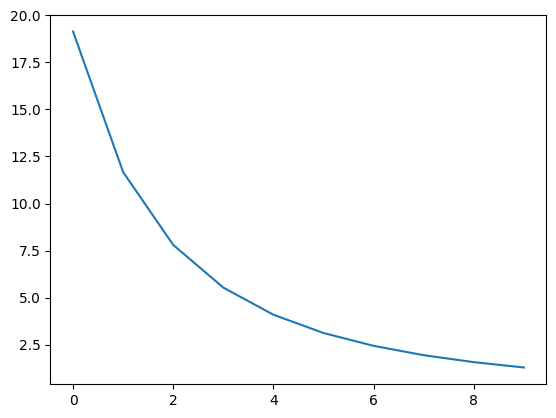

In [123]:
plt.plot(funk_model.hist["mse"][:10])

In [131]:
user_id = 1
item_id = 3705

pred = funk_model.predict_rating(user_id=user_id, item_id=item_id)
pred

np.float64(2.7908348146392563)

4. **Recommendation Algorithm**

    - Develop an algorithm to suggest one movie that might be liked by the couple of users. You can use the criteria you prefer to create a "couple score" for each movie and then sort the movies by the score.

J'ai choisi de prendre en compte les genres favoris des utilisateurs en leur attribuant un certain ratio. En effet, j'ai observé que lorsque le ratio dépasse 0,5, les genres des films recommandés tendent à être presque toujours les mêmes, tandis qu'avec un ratio inférieur, la diversité des genres augmente. Cela nous permet d'ajuster les recommandations en fonction des préférences spécifiques de chaque utilisateur.

In [155]:
def predict_movie_couple(user1_id, user2_id, funk_model, movies, importance_genre_ratio = 0.3):
    user1 = funk_model.user_mat_[user1_id - 1, :]
    user2 = funk_model.user_mat_[user2_id - 1, :]
    
    movies_average = ((user1 @ funk_model.item_mat_) + (user2 @ funk_model.item_mat_)) / 2
    
    common_genres = find_common_favorite_genres(user1_id, user2_id, ratings, movies)
    common_genres /= common_genres.sum()
    

    movies_reduced = movies[["MovieID", "Genres"]].copy()

    genre_weights_dict = common_genres.to_dict()


    def calculate_weighted_genre_score(genres):
        # Calculate the weighted score by summing weights for the present genres
        if genres:
            # Calculate the weighted score by summing weights for the present genres
            total_weight = sum(genre_weights_dict.get(genre, 0) for genre in genres)
            # Normalize by the number of genres that have a non-zero weight
            num_genres = sum(1 for genre in genres if genre_weights_dict.get(genre, 0) > 0)
            # Avoid division by zero
            if num_genres > 0:
                return total_weight / num_genres
            else:
                return 0
        else:
            return 0

    
    movies_reduced['Weighted_Genre_Score'] = movies_reduced['Genres'].apply(calculate_weighted_genre_score)

    # Take into account the genre for each movie
    final_scores = movies_average + movies_average * movies_reduced['Weighted_Genre_Score'].values * importance_genre_ratio

    movies.loc[:, 'Final_Score'] = final_scores

    top_10_indices = np.argsort(final_scores)[-10:][::-1]
    top_10_movies = movies.iloc[top_10_indices]
    return top_10_movies[['MovieID', 'Title', 'Genres', 'Year', 'Rating', 'Final_Score']]


top_10_movies_couple = predict_movie_couple(911, 151, funk_model=funk_model, movies=movies_final)
top_10_movies_couple

,MovieID,Title,Genres,Year,Rating,Final_Score
977,989,Schlafes Bruder (Brother of Sleep),[Drama],1995,5.000000,5.991116
3587,3656,Lured,[Crime],1947,5.000000,5.967775
2868,2937,"Palm Beach Story, The",[Comedy],1942,4.288462,5.956314
52,53,Lamerica,[Drama],1994,4.750000,5.929811
3313,3382,Song of Freedom,[Drama],1936,5.000000,5.886128
1773,1842,Illtown,"[Crime, Drama]",1996,4.000000,5.826781
3164,3233,Smashing Time,[Comedy],1967,5.000000,5.741350
2240,2309,"Inheritors, The (Die Siebtelbauern)",[Drama],1998,4.500000,5.719048
1256,1276,Cool Hand Luke,"[Comedy, Drama]",1967,4.253763,5.609801
1267,1287,Ben-Hur,"[Action, Adventure, Drama]",1959,4.110795,5.583650


5. **Evaluation**

    - Split the data into training and testing sets.
    - Evaluate the model, choose the metric you prefer.

Initialement, j'envisageais de diviser les données, mais j'ai réalisé que cela entraînerait l'absence de certaines données dans le modèle, ce qui nous empêcherait de les prédire. Par ailleurs, le modèle effectue déjà une sorte de vérification de l'erreur quadratique moyenne (MSE) tout au long de l'entraînement. Toutefois, il reste possible de séparer le masque en proportions de 80/20 pour observer si une différence significative apparaît entre les valeurs initiales de test et celles obtenues à la fin.

In [17]:
indices = np.where(r_mask)

# Mélanger aléatoirement ces indices
shuffled_indices = np.random.permutation(len(indices[0]))

# Calculer le point de séparation pour 80% des données
split_point = int(len(shuffled_indices) * 0.8)

# Créer les masques de train et de test
train_mask = np.zeros_like(r_mask, dtype=bool)
test_mask = np.zeros_like(r_mask, dtype=bool)

# Affecter 80% des indices au train et 20% au test
train_indices = tuple(idx[shuffled_indices[:split_point]] for idx in indices)
test_indices = tuple(idx[shuffled_indices[split_point:]] for idx in indices)

train_mask[train_indices] = True
test_mask[test_indices] = True

In [19]:
n_users, n_items = user_item_matrix.shape
r_mask = user_item_matrix_zeros > 0
latent_dim = 120

funk_model_validation = FunkSVD(latent_dim=latent_dim)
funk_model_validation.fit(user_item_matrix.values, train_mask, n_users, n_items, max_iter=300, learning_rate=5.0e-3)

INFO:root:Training complete.
        
Mean squared error: 0.033


In [23]:
user_item_matrix_zeros = user_item_matrix_zeros.to_numpy()


test_users, test_items = np.where(test_mask)

predicted_ratings = []
for user_id, item_id in zip(test_users, test_items):
    predicted_rating = funk_model_validation.predict_rating(user_id + 1, item_id + 1)
    predicted_ratings.append(predicted_rating)

predicted_ratings = np.array(predicted_ratings)

true_ratings = user_item_matrix_zeros[test_users, test_items]

mse = np.mean((true_ratings - predicted_ratings) ** 2)
rse = np.sqrt(mse)

print(f"L'erreur quadratique moyenne (MSE) est : {mse}")
print(f"L'erreur quadratique racine (RSE) est : {rse}")


L'erreur quadratique moyenne (MSE) est : 1.491772301715121
L'erreur quadratique racine (RSE) est : 1.2213813088937955


6. **Les test non concluants**
    - NMF, pour ce modèle j'ai eu beaucoup de mal à le faire converger et les résultats semblaient moyens.
    - SVD, les résultats semblaient beaucoup trop influencés par les notes qui n'avaient pas été encore mise.

**NMF**

1
2
3


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


4


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


5


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


6


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


7


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


8


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


9


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


10


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


11


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


12


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


13


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


14


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


15


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


16


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


17


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


18


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


19


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


20


c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


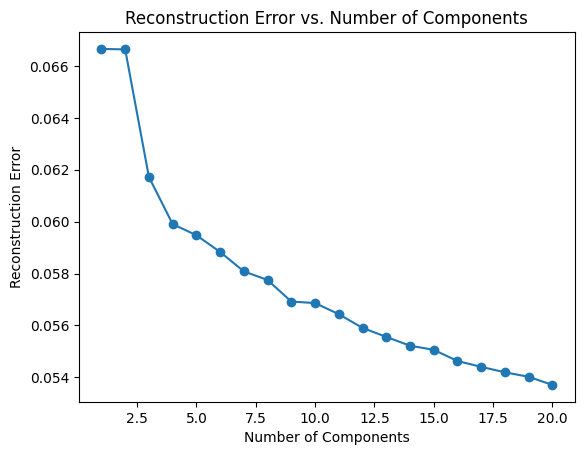

In [ ]:
errors = []
range_of_components = range(1, 21)

for n_components in range_of_components:
    print(n_components)
    model = NMF(n_components=n_components, init='random', random_state=0)
    W = model.fit_transform(user_item_matrix)
    H = model.components_
    reconstructed = np.dot(W, H)
    error = mean_squared_error(user_item_matrix, reconstructed)
    errors.append(error)

# Plotting the error
plt.plot(range_of_components, errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs. Number of Components')
plt.show()


In [ ]:
model = NMF(n_components=50, init='random', random_state=42, max_iter=500)
W = model.fit_transform(user_item_matrix)
H = model.components_

reconstructed = np.dot(W, H)
error = mean_squared_error(user_item_matrix, reconstructed)
print(error)
print(reconstructed)

c:\Users\rokra\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


0.048137861519880566
[[4.25703048 4.16359477 4.14748113 ... 4.14142094 4.14974675 4.14614107]
 [3.24439519 3.20872013 3.24647496 ... 3.17974139 3.1991012  3.25830815]
 [3.42870727 3.16047427 3.04568083 ... 2.99479993 3.01730736 2.93729813]
 ...
 [3.85326522 3.27318016 3.18267143 ... 3.25157926 3.24195862 3.32661667]
 [3.81294823 3.16131079 3.17950818 ... 3.24346455 3.22327763 3.30575272]
 [3.53241711 3.22948032 3.12108985 ... 3.29818501 3.30531297 3.3593454 ]]


In [ ]:
reconstructed_df = pd.DataFrame(reconstructed, index=user_item_matrix.index, columns=user_item_matrix.columns)

In [ ]:
reconstructed_df

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,4.257030,4.163595,4.147481,4.123441,4.132752,4.133188,4.121989,4.145063,4.158863,4.124086,...,4.126335,4.144387,4.125197,4.111136,4.132511,4.165444,4.146357,4.141421,4.149747,4.146141
2,3.244395,3.208720,3.246475,3.224241,3.216268,3.117596,3.238045,3.174875,3.154183,3.274911,...,3.207373,3.212604,3.216803,3.189543,3.176792,3.210590,3.154350,3.179741,3.199101,3.258308
3,3.428707,3.160474,3.045681,3.053679,3.032128,3.042606,3.047211,3.029733,3.024277,3.144435,...,3.001865,3.002255,2.976913,3.016991,3.011796,3.022050,3.015107,2.994800,3.017307,2.937298
4,2.766113,2.775520,2.714233,2.733195,2.752265,2.848259,2.753912,2.729408,2.741014,2.734832,...,2.741054,2.713924,2.729138,2.743633,2.718866,2.713080,2.779002,2.727622,2.739246,2.711005
5,3.139568,2.987986,3.106248,2.973731,3.012283,3.149026,2.953024,3.038555,3.031006,3.064663,...,3.020985,2.987825,3.011406,2.952806,2.969318,2.970938,3.188002,2.996037,3.010337,2.975664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.956600,2.840985,3.158863,3.201077,3.244388,3.635226,3.024827,3.288171,3.141732,3.244963,...,3.160512,3.145835,3.190234,3.051735,3.294158,3.405959,3.890757,3.328016,3.284831,3.474757
6037,3.664299,3.255595,3.282190,3.190182,3.232534,3.184879,3.212018,3.224598,3.220800,3.283079,...,3.235631,3.244047,3.194380,3.235200,3.242929,3.310597,3.351446,3.249171,3.242903,3.317978
6038,3.853265,3.273180,3.182671,3.221017,3.218596,3.344210,3.280309,3.233079,3.207443,3.341305,...,3.230209,3.237163,3.217275,3.210682,3.257337,3.362814,3.272979,3.251579,3.241959,3.326617


**SVD**

In [ ]:
# Perform SVD
U, s, VT = svd(user_item_matrix, full_matrices=False)

# Make the Sigma matrix in the correct shape for matrix multiplication
Sigma = np.diag(s)

# Reconstruct the matrix
ratings_approximated = np.dot(U, np.dot(Sigma, VT))
ratings_approximated_df = pd.DataFrame(ratings_approximated, index=user_item_matrix.index, columns=user_item_matrix.columns)

In [ ]:
ratings_approximated_df

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.000000,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846,...,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846,4.146846
2,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,...,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141,3.201141
3,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,...,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736,3.016736
4,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,...,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412,2.729412
5,3.006757,3.006757,3.006757,3.006757,3.006757,2.000000,3.006757,3.006757,3.006757,3.006757,...,3.006757,3.006757,3.006757,3.006757,3.006757,3.006757,3.006757,3.006757,3.006757,3.006757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.660933,3.236181,3.213638,2.000000,3.223264,3.000000,3.256998,3.236634,3.221084,3.306746,...,3.234539,3.236810,3.219668,3.212319,3.241835,3.321398,3.307676,3.244365,3.245541,3.289894
6037,3.660933,3.236181,3.213638,3.215171,3.223264,3.386332,3.256998,3.236634,3.221084,3.306746,...,3.234539,3.236810,3.219668,3.212319,3.241835,3.321398,3.307676,3.244365,3.245541,3.289894
6038,3.660933,3.236181,3.213638,3.215171,3.223264,3.386332,3.256998,3.236634,3.221084,3.306746,...,3.234539,3.236810,3.219668,3.212319,3.241835,3.321398,3.307676,3.244365,3.245541,3.289894
